US map shape files retrieved from at https://www.census.gov/cgi-bin/geo/shapefiles/index.php

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

In [2]:
def get_continental_counties(path_to_state_counties_tsv, path_to_counties_shp, path_to_states_shp):
    state_name_map = gpd.read_file(path_to_states_shp)[["STATEFP", "NAME"]].set_index("STATEFP")["NAME"]

    df = pd.read_csv(path_to_state_counties_tsv, sep="\t")[["state", "county"]]
    df = df.set_index(df["state"] + ", " + df["county"])

    gdf = gpd.read_file(path_to_counties_shp)[["STATEFP", "NAMELSAD", "geometry"]]
    gdf = gdf.set_index(gdf["STATEFP"].apply(lambda x: state_name_map[x]) + ", " + gdf["NAMELSAD"])

    return gdf.join(df, how="right")[["geometry"]]

In [3]:
us_df = get_continental_counties("maps/us_state_counties.tsv", "maps/unzipped/tl_2022_us_county/tl_2022_us_county.shp", "maps/unzipped/tl_2022_us_state/tl_2022_us_state.shp")
us_df.head()

,geometry
"Alabama, Autauga County","POLYGON ((-86.58826 32.36775, -86.58834 32.367..."
"Alabama, Baldwin County","POLYGON ((-87.97692 31.08658, -87.97688 31.087..."
"Alabama, Barbour County","POLYGON ((-85.41585 31.68164, -85.41619 31.677..."
"Alabama, Bibb County","POLYGON ((-86.87657 33.01891, -86.87657 33.018..."
"Alabama, Blount County","POLYGON ((-86.56421 33.80194, -86.56556 33.801..."


In [4]:
def get_line_scores(line):
    word_counts = pd.Series(line.split()).value_counts()
    n = word_counts.sum()
    n_yes = word_counts.get("yes", 0)
    n_no = word_counts.get("no", 0)
    n_other = n - n_yes - n_no
    return (n_yes / n, n_no / n, n_other / n)

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_scores(dfs: list, name, score_field="score", dpi=150):
    if type(dfs) != list:
        dfs = [dfs]
    
    f, ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=dpi)
    plt.title(f"Occurrence map of {name}")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
    for df in dfs:
        df.plot(score_field, ax=ax, alpha=0.5, cmap='Reds', edgecolor='k', legend=True, cax=cax, linewidth=0.1)
    plt.show()

In [6]:
def get_llm_scores(df, path):
    df = df.copy()
    df["score"] = pd.Series([get_line_scores(line.split("\t")[0].lower())[0] for line in open(path, "r")][1:], index=df.index)
    return df

`results/d3_gpt35.tsv`
- Query: "Can {0} {1} be found in {3}, {2}? Yes or no"
- top_p: 0.8

In [7]:
get_llm_scores(us_df, "results/d3_gpt35.tsv").head()

,geometry,score
"Alabama, Autauga County","POLYGON ((-86.58826 32.36775, -86.58834 32.367...",1.0
"Alabama, Baldwin County","POLYGON ((-87.97692 31.08658, -87.97688 31.087...",1.0
"Alabama, Barbour County","POLYGON ((-85.41585 31.68164, -85.41619 31.677...",1.0
"Alabama, Bibb County","POLYGON ((-86.87657 33.01891, -86.87657 33.018...",1.0
"Alabama, Blount County","POLYGON ((-86.56421 33.80194, -86.56556 33.801...",1.0


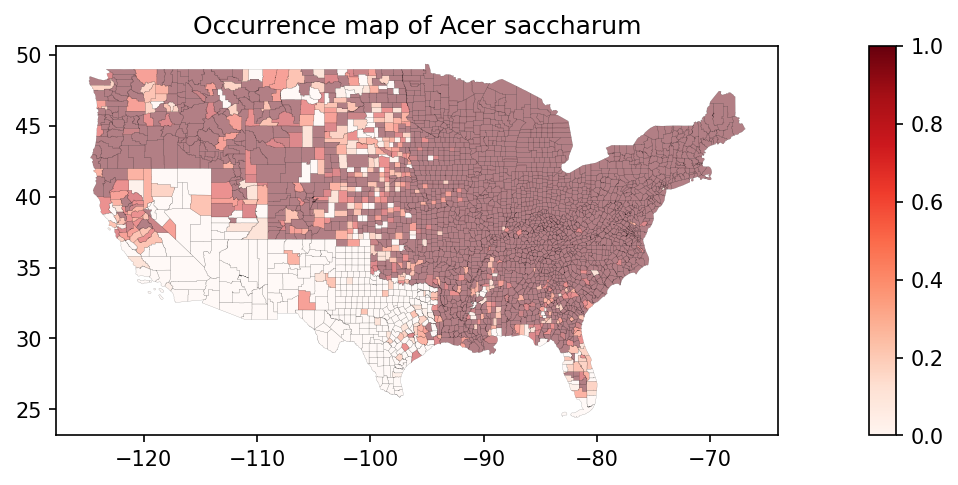

In [8]:
plot_scores(get_llm_scores(us_df, "results/d3_gpt35.tsv"), "Acer saccharum")

`results/d3_gpt35_2.tsv`
- Query: "Does {0} {1} naturally occur in {3}, {2}? Yes or no"
- top_p: 0.8

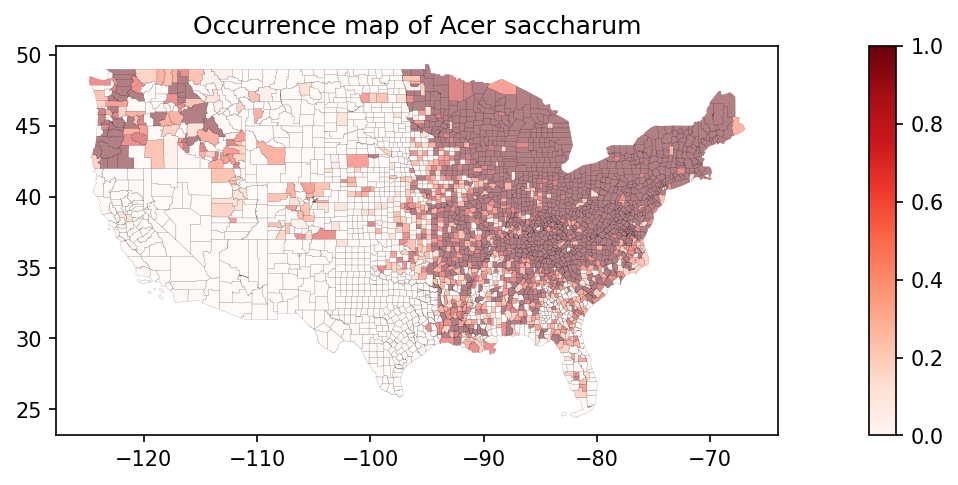

In [9]:
plot_scores(get_llm_scores(us_df, "results/d3_gpt35_2.tsv"),"Acer saccharum")

`results/d3-acer-saccharum-latlon_gpt35_sorted.tsv`

```bash
$ cat maps/us-state-counties.tsv | python ../scripts/nlp/qa.py "Does Acer saccharum naturally occur at latitude {2}, longitude {3}? Yes or no"
```

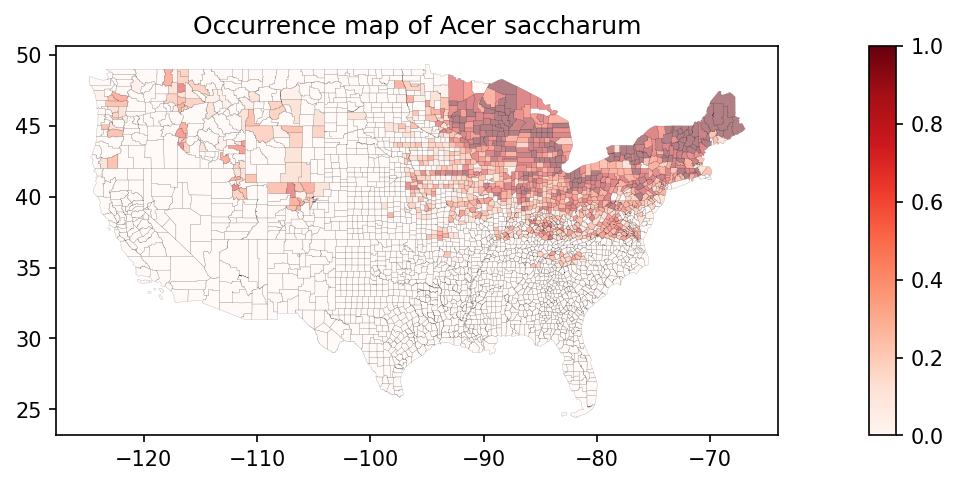

In [10]:
plot_scores(get_llm_scores(us_df, "results/d3-acer-saccharum-latlon_gpt35_sorted.tsv"), "Acer saccharum")

`results/d3-sugar-maple-latlon_gpt35_sorted.tsv`

```bash
$ cat maps/us-state-counties.tsv | python ../scripts/nlp/qa.py "Do sugar maples naturally occur at latitude {2}, longitude {3}? Yes or no"
```

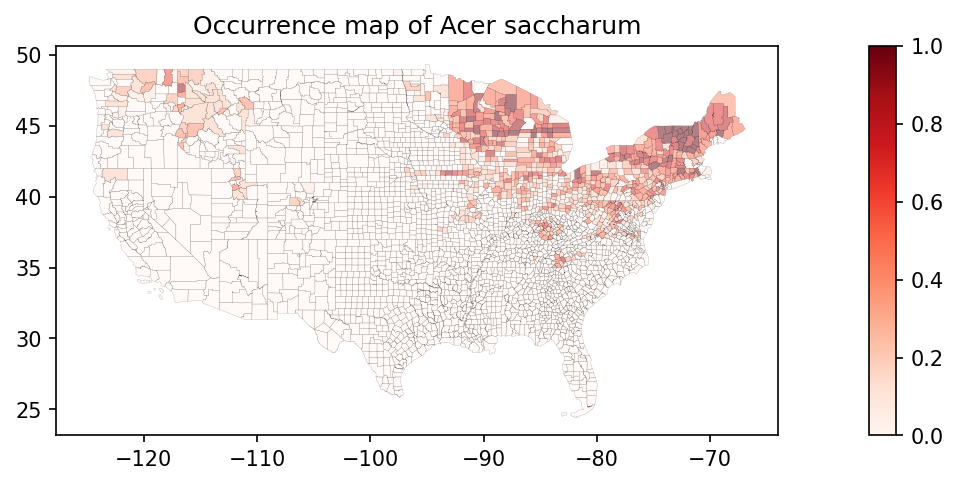

In [11]:
plot_scores(get_llm_scores(us_df, "../results/d3-sugar-maple-latlon_gpt35_sorted.tsv"), "Sugar Maple")

In [10]:
def get_record_counts(df, path):
    county_counts = pd.Series([line.rstrip().split("\t")[2] for line in open(path, "r")][1:], index=df.index)
    df["score"] = county_counts.apply(lambda x: min(1, int(x)))
    return df

def plot_record_counts(name, path):
    file_name = path.split("/")[-1]
    counties_df = get_record_counts(counties_df, path)
    plot_scores(counties_df, f"{name} ({file_name})")

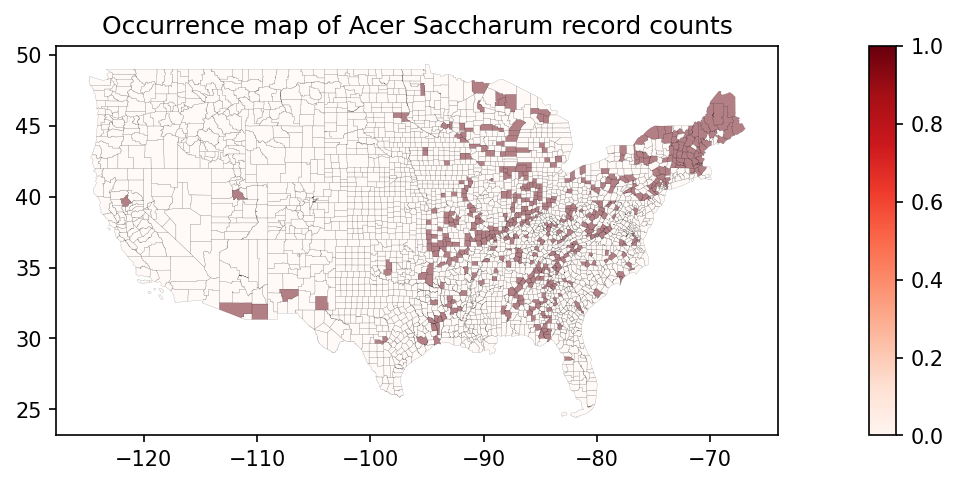

In [12]:
plot_scores(get_record_counts(us_df, "maps/us-county-acer-saccharum-idigbio-counts.tsv"), "Acer Saccharum record counts")

In [16]:
shp_file = "maps/unzipped/mex_admbnda_govmex_20210618_shp/mex_admbnda_govmex_20210618_SHP/mex_admbnda_adm2_govmex_20210618.shp"
mex_df = gpd.read_file(shp_file)[["ADM1_ES", "ADM2_ES", "geometry"]].sort_values(["ADM1_ES", "ADM2_ES"])
mex_df = mex_df.set_index(mex_df["ADM1_ES"] + ", " + mex_df["ADM2_ES"])[["geometry"]]
mex_df.head()

,geometry
"Aguascalientes, Aguascalientes","POLYGON ((-102.09775 22.02325, -102.09857 22.0..."
"Aguascalientes, Asientos","POLYGON ((-101.99941 22.21951, -101.99940 22.2..."
"Aguascalientes, Calvillo","POLYGON ((-102.57625 21.96778, -102.57626 21.9..."
"Aguascalientes, Cosío","POLYGON ((-102.25320 22.37449, -102.25239 22.3..."
"Aguascalientes, El Llano","POLYGON ((-101.89778 21.95839, -101.89037 21.9..."


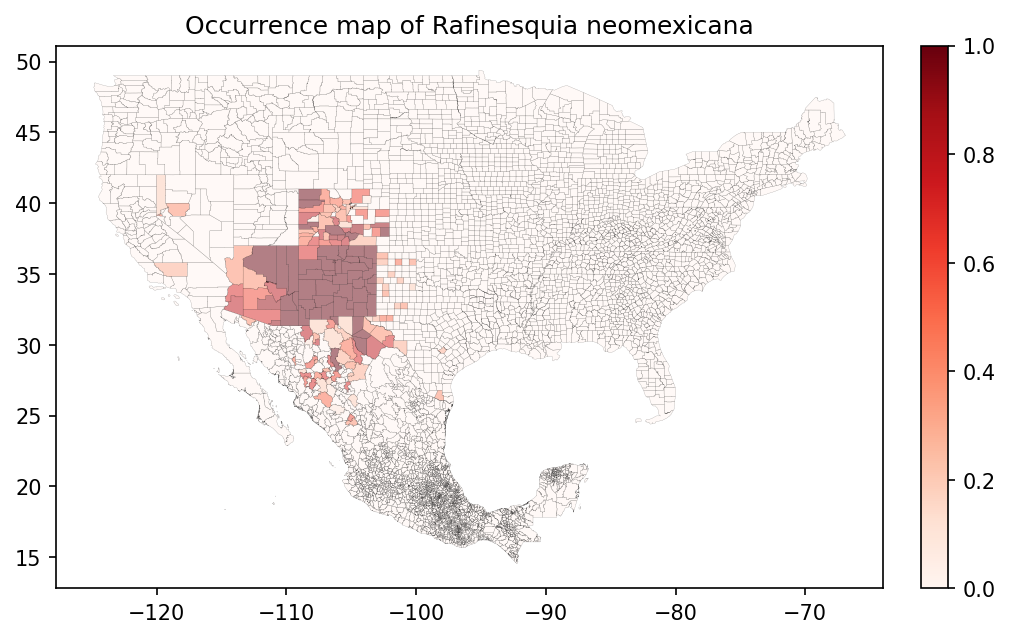

In [18]:
plot_scores([get_llm_scores(df, scores) for df, scores in 
             ((us_df, "results/us_county_raf_neo.tsv"), (mex_df, "results/mex_muni_raf_neo.tsv"))],
             "Rafinesquia neomexicana")

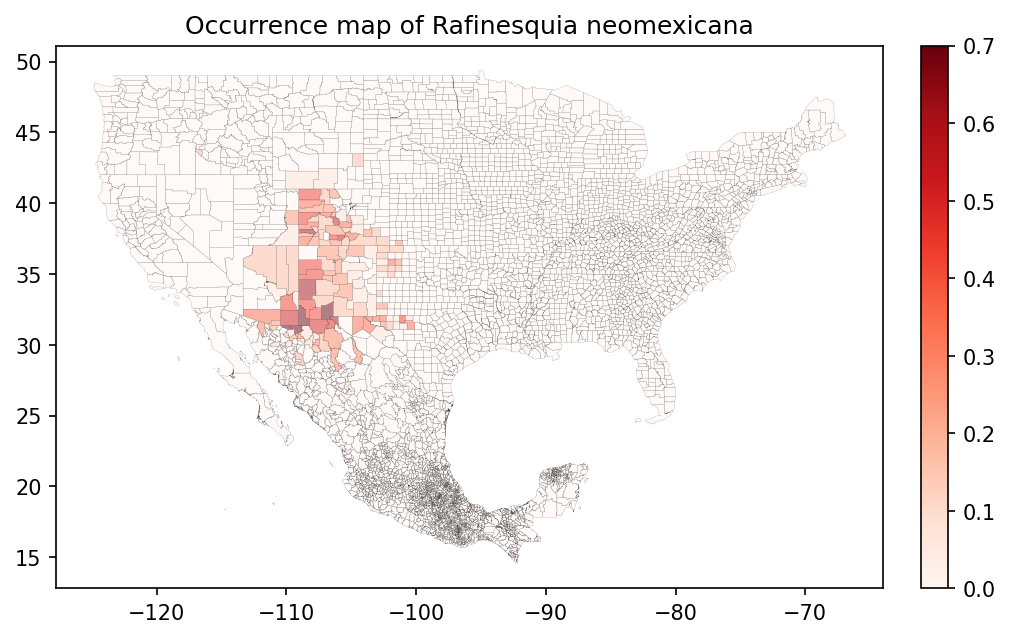

In [19]:
plot_scores([get_llm_scores(df, scores) for df, scores in 
             ((us_df, "results/us_lat_lon_raf_neo.tsv"), (mex_df, "results/mex_lat_lon_raf_neo.tsv"))],
             "Rafinesquia neomexicana")

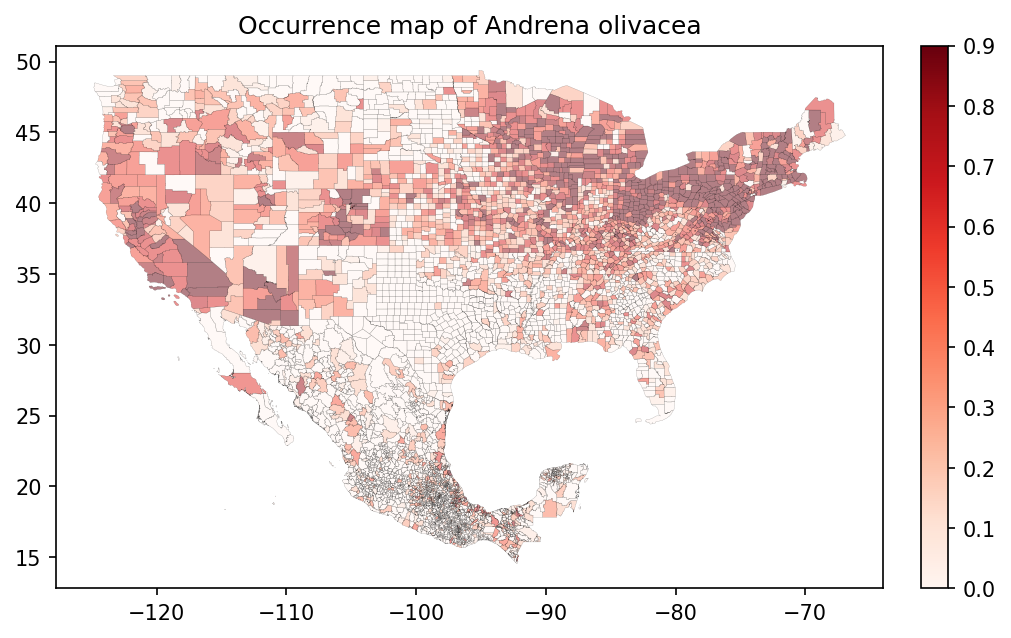

In [20]:
plot_scores([get_llm_scores(df, scores) for df, scores in 
             ((us_df, "results/us_admin_and_oli.tsv"), (mex_df, "results/mex_admin_and_oli.tsv"))],
             "Andrena olivacea")

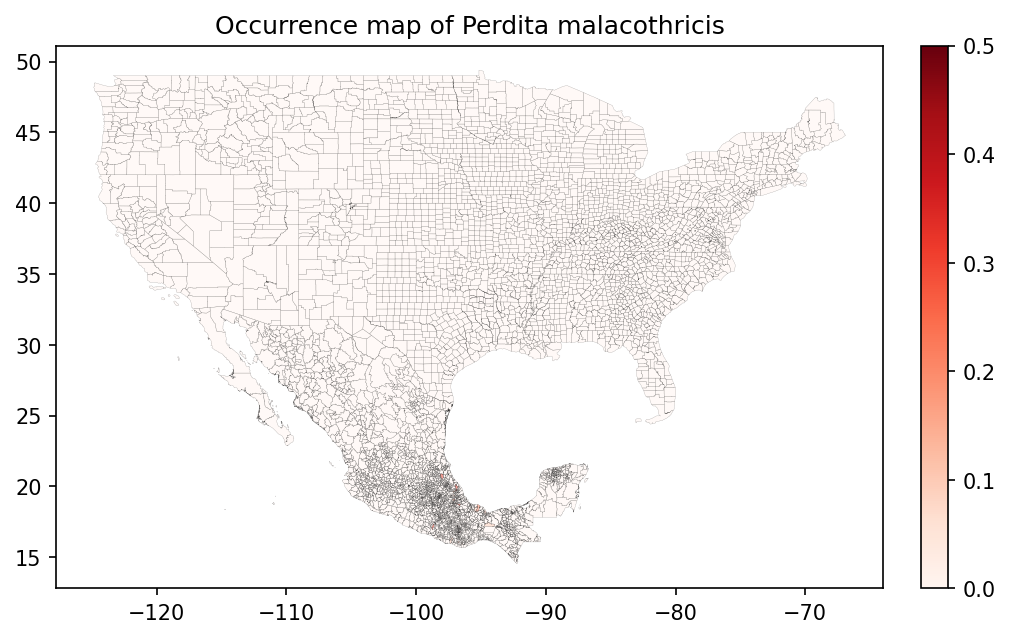

In [21]:
plot_scores([get_llm_scores(df, scores) for df, scores in 
             ((us_df, "results/us_admin_per_mal.tsv"), (mex_df, "results/mex_admin_per_mal.tsv"))],
             "Perdita malacothricis")